In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
!cp -r /content/drive/MyDrive/avito/project/auto-10k .
!cp -r /content/drive/MyDrive/avito/project/model_training/masks .

In [3]:
!pip install -U segmentation-models-pytorch -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 9.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 99.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 31.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 89.2 MB/s eta 0:00:00


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import random 
import albumentations as A
import torchvision
from torchvision import transforms as T
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from IPython.display import clear_output
import torch
from PIL import Image

In [5]:
ANN_FILE = '/content/drive/MyDrive/avito/project/model_training/annotation.csv'
IMAGES_DIR = 'auto-10k'
MASKS_DIR = 'masks'

SEED = 42
BATCH_SIZE = 32
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
seed_everything(SEED)

In [7]:
annot = pd.read_csv(ANN_FILE)

In [8]:
annot['image'] = annot['image'].apply(lambda s: os.path.join(IMAGES_DIR, s))
annot['mask'] = annot['mask'].apply(lambda s: os.path.join(MASKS_DIR, s))

In [13]:
MEAN = np.array([0.485, 0.456, 0.406])
STD = np.array([0.229, 0.224, 0.225])

train_transforms = A.Compose([
    
    #A.CropAndPad(percent=0.05, p=0.5),
    A.Resize(224, 224),
    
    A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.5),
    A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.GaussNoise(var_limit=(10.0, 50.0), mean=0, p=0.5),
    A.Normalize(MEAN, STD),
    ToTensorV2(), 
  ],  
  additional_targets={'image1': 'mask'})


val_transforms = A.Compose([
    A.Resize(520, 520),
    
    A.Normalize(MEAN, STD),
    ToTensorV2(),
])

In [10]:
class ImageDataset(Dataset):
    
    def __init__(self, images, masks, transforms):
        
        super(ImageDataset).__init__()
        self.images = images
        self.masks = masks
        self.transforms = transforms

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
       
        image = plt.imread(self.images[index])
        mask = plt.imread(self.masks[index])
        transformed = self.transforms(image=image, mask=mask)
        return transformed['image'], (transformed['mask']*255).int()[None, :, :]

In [14]:
train_images,rest_images, train_masks, rest_masks = train_test_split(annot['image'].values,
                                                                    annot['mask'].values,
                                                                    random_state=42, train_size=0.8)
val_images,test_images, val_masks, test_masks = train_test_split(rest_images,
                                                                 rest_masks,
                                                                 random_state=42, test_size=0.5)

train_dataset = ImageDataset(train_images, train_masks, train_transforms)
val_dataset = ImageDataset(val_images, val_masks, val_transforms)
test_dataset = ImageDataset(test_images, test_masks, val_transforms)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [15]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_mobilenet_v3_large', pretrained=True)
model.to(DEVICE)
model.eval()

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_MobileNet_V3_Large_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride

In [16]:
iou_scores = []

for x, y in test_dataloader:
  with torch.no_grad():

    preds = model(x.to(DEVICE))['out']

    preds = preds.argmax(1)
    preds[preds != 7] = 0
    preds[preds == 7] = 1

    preds = preds[:, None, :, :]

    tp, fp, fn, tn = smp.metrics.get_stats(preds, y.to(DEVICE), mode='multilabel', threshold=0.5)
    iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")

    iou_scores.append(iou_score.cpu())

In [17]:
sum(iou_scores) / len(iou_scores)

tensor(0.7577)

In [18]:
iou_scores

[tensor(0.7661), tensor(0.7494)]

In [ ]:
output_predictions.unique()

tensor([0, 7], device='cuda:0')

In [ ]:
output_predictions[output_predictions != 7] = 0
output_predictions[output_predictions == 7] = 1

In [ ]:
output_predictions.unique()

tensor([0, 1], device='cuda:0')

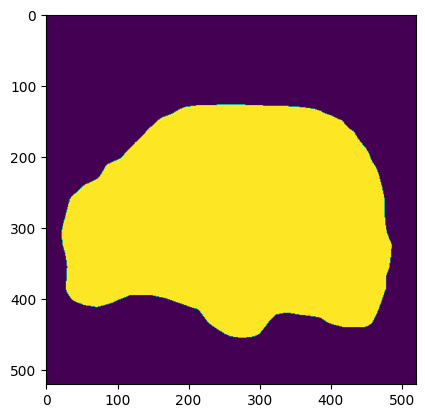

In [ ]:
plt.imshow(output_predictions.cpu().numpy())

In [ ]:
torchvision.models.segmentation.DeepLabV3_MobileNet_V3_Large_Weights.DEFAULT.meta['categories'][7]

'car'